In [1]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
def rgb2gray(rgb):
  return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [3]:
#load the CIFAR10 data
(x_train, _), (x_test, _) = cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


In [4]:
#input image data
img_rows = x_train.shape[1]
img_cols = x_train.shape[2]
channels = x_train.shape[3]

In [5]:
#create saved_images folder
imgs_dir = 'saved_images'
save_dir = os.path.join(os.getcwd(), imgs_dir)
if not os.path.isdir(save_dir):
  os.makedirs(save_dir)

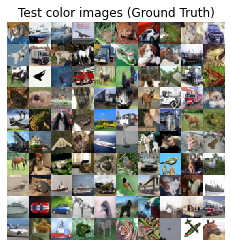

In [6]:
#display the 1st 100 input images (color and gray)
imgs = x_test[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test color images (Ground Truth)')
plt.imshow(imgs, interpolation='none')
plt.savefig('%s/test_color.png' %imgs_dir)
plt.show()

In [7]:
#convert color train and test images to gray
x_train_gray = rgb2gray(x_train)
x_test_gray = rgb2gray(x_test)

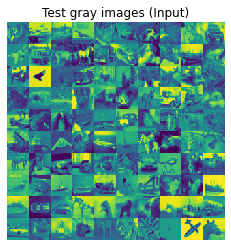

In [8]:
#display grayscale version of test images
imgs = x_test_gray[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test gray images (Input)')
plt.imshow(imgs, interpolation='none')
plt.savefig('%s/test_gray.png' %imgs_dir)
plt.show()

In [9]:
#normalize output train and test color images
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

In [10]:
#normalize input train and test gray images
x_train_gray = x_train_gray.astype('float32')/255
x_test_gray = x_test_gray.astype('float32')/255

In [11]:
#reshape images to row x col x channel for CNN output/validation
x_train = x_train.reshape((x_train.shape[0], img_rows, img_cols, channels))
x_test = x_test.reshape((x_test.shape[0], img_rows, img_cols, channels))

In [12]:
#reshape images to row x col x channel for CNN input
x_train_gray = x_train_gray.reshape((x_train_gray.shape[0], img_rows, img_cols, 1))
x_test_gray = x_test_gray.reshape((x_test_gray.shape[0], img_rows, img_cols, 1))

In [13]:
#network parameters
input_shape = (img_rows, img_cols, 1)
batch_size = 32
kernel_size = 3
latent_dim = 16
#encoder/decoder number of CNN layers and filters per layer
layer_filters = [64, 128, 256]

In [14]:
#first build the encoder model
inputs = Input(shape=input_shape, name = 'encoder_input')
x = inputs
#stack for Conv2D(64) - Conv2D(128) - Conv2D(256)
for filters in layer_filters:
  x = Conv2D(filters=filters,
             kernel_size=kernel_size,
             padding='same',
             strides=2,
             activation='relu')(x)

shape = K.int_shape(x)

#generate a latent vactor
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)
#instantiate encoder model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)         295168    
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                65552     
Total params: 435,216
Trainable params: 435,216
Non-trainable params: 0
_____________________________________________________

In [15]:
#second build the decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)
#stack for Conv2DTranspose(256) - Conv2DTranspose(128) - Conv2DTranspose(64)
for filter in layer_filters[::-1]:
  x = Conv2DTranspose(filters=filters,
                      kernel_size=kernel_size,
                      padding='same',
                      strides=2,
                      activation='relu')(x)

outputs = Conv2DTranspose(filters=channels,
                          kernel_size=kernel_size,
                          padding='same',
                          activation='sigmoid',
                          name='decoder_output')(x)

#instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 16)]              0         
_________________________________________________________________
dense (Dense)                (None, 4096)              69632     
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 256)         590080    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 256)       590080    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 32, 32, 256)       590080    
_________________________________________________________________
decoder_output (Conv2DTransp (None, 32, 32, 3)         6915

In [16]:
#autoencoder = encoder + decoder
#instantiate auoencoder model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 32, 32, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 16)                435216    
_________________________________________________________________
decoder (Functional)         (None, 32, 32, 3)         1846787   
Total params: 2,282,003
Trainable params: 2,282,003
Non-trainable params: 0
_________________________________________________________________


In [17]:
# prepare model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'colorized_ae_model.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
 os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

In [18]:
# reduce learning rate by sqrt(0.1) if the loss does not improve in 5 epochs
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-6)
# save weights for future use (e.g. reload parameters w/o training)
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)
#Loss function : MSE, Optimizer : Adam
autoencoder.compile(loss='mse', optimizer='adam') 

In [19]:
# called every epoch
callbacks = [lr_reducer, checkpoint]

In [20]:
# train the autoencoder
autoencoder.fit(x_train_gray,
                x_train,
                validation_data=(x_test_gray, x_test),
                epochs=30,
                batch_size=batch_size,
                callbacks=callbacks)

Epoch 1/30
1563/1563 [==============================] - ETA: 0s - loss: 0.0219
Epoch 00001: val_loss improved from inf to 0.01973, saving model to /content/saved_models/colorized_ae_model.001.h5
1563/1563 [==============================] - 33s 21ms/step - loss: 0.0219 - val_loss: 0.0197
Epoch 2/30
1561/1563 [============================>.] - ETA: 0s - loss: 0.0193
Epoch 00002: val_loss improved from 0.01973 to 0.01922, saving model to /content/saved_models/colorized_ae_model.002.h5
1563/1563 [==============================] - 34s 22ms/step - loss: 0.0193 - val_loss: 0.0192
Epoch 3/30
1561/1563 [============================>.] - ETA: 0s - loss: 0.0191
Epoch 00003: val_loss improved from 0.01922 to 0.01910, saving model to /content/saved_models/colorized_ae_model.003.h5
1563/1563 [==============================] - 33s 21ms/step - loss: 0.0191 - val_loss: 0.0191
Epoch 4/30
1561/1563 [============================>.] - ETA: 0s - loss: 0.0189
Epoch 00004: val_loss improved from 0.01910 to 0.

In [21]:
# predict the autoencoder output from test data
x_decoded = autoencoder.predict(x_test_gray)

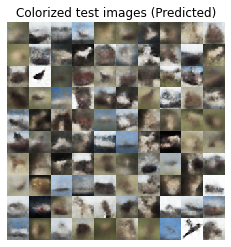

In [22]:
# display the 1st 100 colorized images
imgs = x_decoded[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Colorized test images (Predicted)')
plt.imshow(imgs, interpolation='none')
plt.savefig('%s/colorized.png' % imgs_dir)
plt.show()